In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
import os
import cv2
import keras
import joblib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import shutil

2025-03-23 15:50:46.434049: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 15:50:46.442097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742755846.450996  212159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742755846.453669  212159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 15:50:46.462797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### Functions

In [3]:
def get_relative_file_paths(folder_path):
    
    """
    Gets a list of relative paths to all files within a given folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        list: A list of relative file paths.
    """

    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths



In [4]:
# METHOD = 'kmeans'
METHOD = 'agglomerative'
# METHOD = 'hdbscan'

NUM_CLUSTERS = 15 #5 # Elejido a mano

MODEL = "AutoEncoder"

INPUT_SHAPE = (128, 128, 3)



#### Paths

In [19]:
# IMAGE_DIR = "../output/cropped_cells_full_v2/media"
IMAGE_DIR = "../output/cropped_cells_full_v3"

# IMAGE_DIR = "./datasets/Abril2023/cropped_cells_augmented_v0"

if MODEL == "AutoEncoder":
    ENCODER_PATH = "../models/encoder_SSIM_MAE_Bparams_vN.keras"
    encoder = keras.saving.load_model(ENCODER_PATH)
else:
    # Load pre-trained models
    if MODEL == 'VGG16':
        preprocess_input = keras.applications.vgg16.preprocess_input
        encoder = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'VGG19':
        preprocess_input = keras.applications.vgg19.preprocess_input
        VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'ResNet50':
        preprocess_input = tf.keras.layers.Identity
        ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'InceptionV3':
        preprocess_input = keras.applications.inception_v3.preprocess_input
        InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'DenseNet121':
        preprocess_input = tf.keras.layers.Identity
        DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    elif MODEL == 'MobileNetV2':
        preprocess_input = tf.keras.layers.Identity
        MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        
    inp = keras.Input(shape=INPUT_SHAPE)
    x = preprocess_input(inp)
    x = encoder(x)
    x = Flatten()(x)
    encoder = Model(inputs=inp, outputs=x)
        
output_path_dataset = f"../output/dataset_test/{MODEL}_{METHOD}_v2"


In [6]:
encoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 2)        │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 2)        │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,702 (45.71 KB)

 Trainable params: 11,578 (45.23 KB)

 Non-trainable params: 124 (496.00 B)

In [7]:
image_paths = sorted(get_relative_file_paths(IMAGE_DIR))


#### Load the images

In [8]:
from tqdm.contrib.concurrent import process_map

def load_image (x):
    if MODEL == "AutoEncoder":
        return cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    else:
        return cv2.imread(x)

/home/nicolas/Documentos/UTN/INA/giar_ina_dev/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

images = process_map(
                load_image,
                image_paths,
                total=len(image_paths),
                max_workers=16,
                chunksize=32,
            )


100%|██████████| 53600/53600 [00:00<00:00, 93096.79it/s] 


## Use encoder embeddings as features

In [10]:
#Transform input images for encoder input
resized_images = [cv2.resize(image, INPUT_SHAPE[0:2]) for image in images]
resized_images = np.array(resized_images)

# images = images/255 # Esto esta incluido en el modelo 

#resized_images = [np.expand_dims(image, axis=(0, -1)) for image in resized_images]

In [11]:
if MODEL == "AutoEncoder":
    resized_images = resized_images / 255.0
    resized_images = np.expand_dims(resized_images, axis=-1)
resized_images.shape

(53600, 128, 128, 1)

In [12]:
encoder.output_shape

(None, 32)

In [13]:
# Extract features from encoder


enc_features_array = np.zeros((resized_images.shape[0], encoder.output_shape[-1]))

batch_size = 256
ini = 0
while True:
    start = ini*batch_size
    end = start+batch_size

    if start >= resized_images.shape[0]:
        break

    if end >= resized_images.shape[0]:
        end = resized_images.shape[0]-1


    this_batch = resized_images[start:end]

    enc_features_array[start:end] = encoder.predict(this_batch, verbose=0)

    ini += 1
    


In [14]:
# enc_features_array_norm = [a / (np.linalg.norm(a) + 1e-16) for a in enc_features_array]
enc_features_array_norm = enc_features_array


In [22]:
NUM_CLUSTERS = 25
METHOD == 'agglomerative'

True

In [23]:
if METHOD == 'kmeans':
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
    kmeans.fit(enc_features_array_norm)

    centroids = kmeans.cluster_centers_
    seleccted_class = -np.ones((len(enc_features_array_norm)), dtype=int)
    for idx, feature in enumerate(enc_features_array_norm):
        dist = 1e99
        for cluster in range(NUM_CLUSTERS):
            t_dist = np.linalg.norm(feature - centroids[cluster])
            if dist > t_dist:
                dist = t_dist
                seleccted_class[idx] = cluster

if METHOD == 'agglomerative':
    from sklearn.cluster import AgglomerativeClustering

    # Aca si o si normalizamos 
    enc_features_array_norm = [a / (np.linalg.norm(a) + 1e-16) for a in enc_features_array]

    # ag_clustering = AgglomerativeClustering(
    #     n_clusters = 15,
    #     metric = 'manhattan',
    #     linkage = 'complete',
    #     # distance_threshold = 1.0,
    #     compute_full_tree = True,
    # )

    ag_clustering = AgglomerativeClustering(
        n_clusters = NUM_CLUSTERS,
        linkage = 'ward',
    )

    clustering = ag_clustering.fit(enc_features_array_norm)
    seleccted_class = clustering.labels_

if METHOD == 'hdbscan':
    from sklearn.cluster import HDBSCAN
    hdb = HDBSCAN(
        min_cluster_size = 50,
        min_samples = 20,
        metric = 'manhattan',
        cluster_selection_method = "leaf"
    )
    clustering = hdb.fit(enc_features_array_norm)
    seleccted_class = clustering.labels_

if METHOD == 'spectral':
    from sklearn.cluster import SpectralClustering
    spectral = SpectralClustering(
        n_clusters = NUM_CLUSTERS
    )
    clustering = spectral.fit(enc_features_array_norm)
    seleccted_class = clustering.labels_


In [26]:
NUM_CLUSTERS = len(np.unique(seleccted_class))
GRID_SIZE = 8
NUM_SHOW = GRID_SIZE*GRID_SIZE

rep_images =[[] for _ in range(NUM_CLUSTERS)]
for cluster in range(NUM_CLUSTERS):
    for idx, label in enumerate(seleccted_class):
        if label >= 0:
            if len(rep_images[label]) < NUM_SHOW:
                rep_images[label].append(resized_images[idx])
                # if label == 1:
                #     print(idx, label)

for rep_idx, rep_list in enumerate(rep_images):
    print(rep_idx, len(rep_list))

0 64
1 64
2 64
3 64
4 64
5 64
6 64
7 64
8 64
9 64
10 64
11 64
12 64
13 64
14 64
15 64
16 64
17 64
18 64
19 64
20 64
21 64
22 64
23 64
24 64


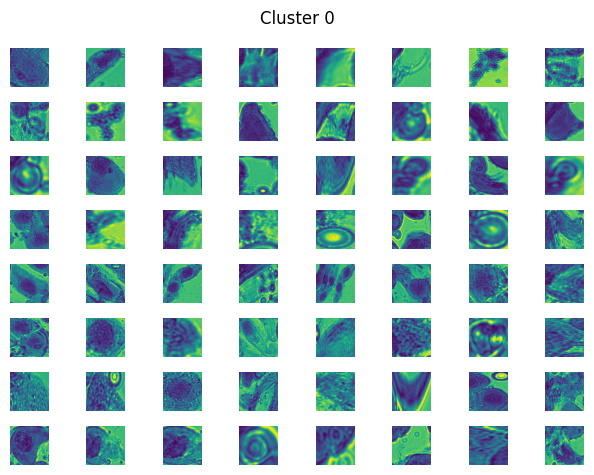

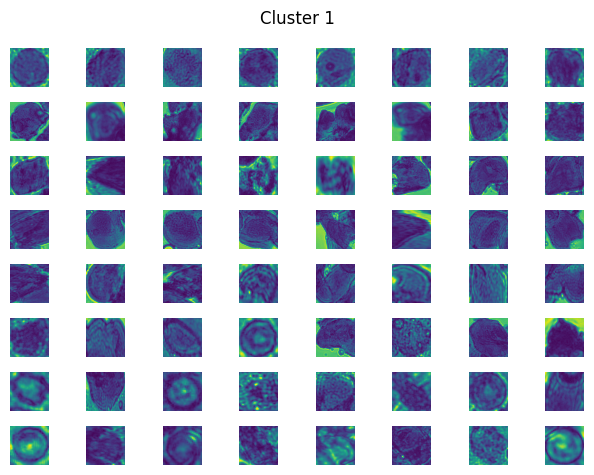

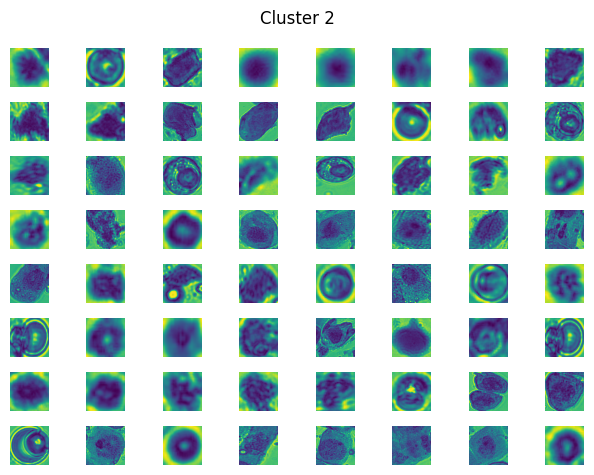

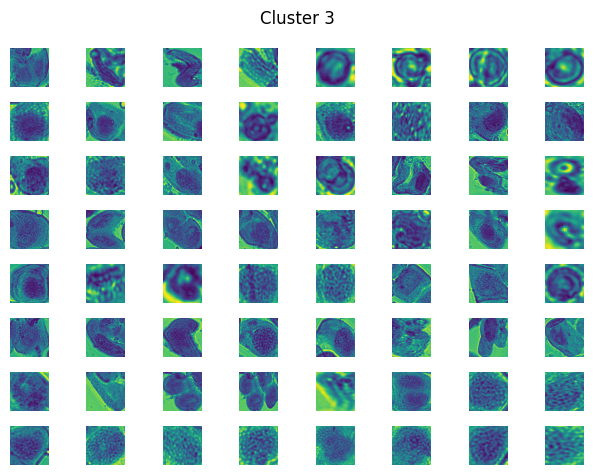

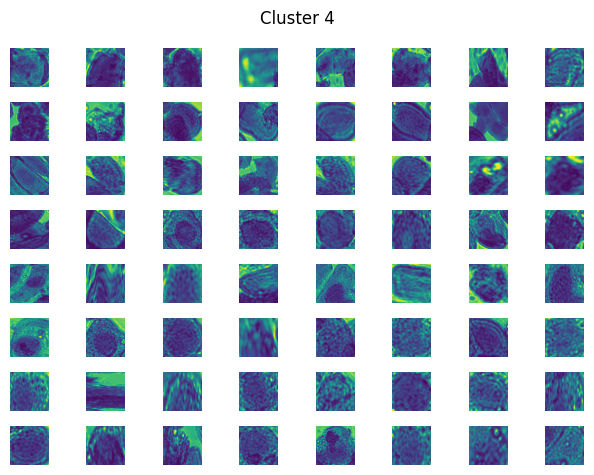

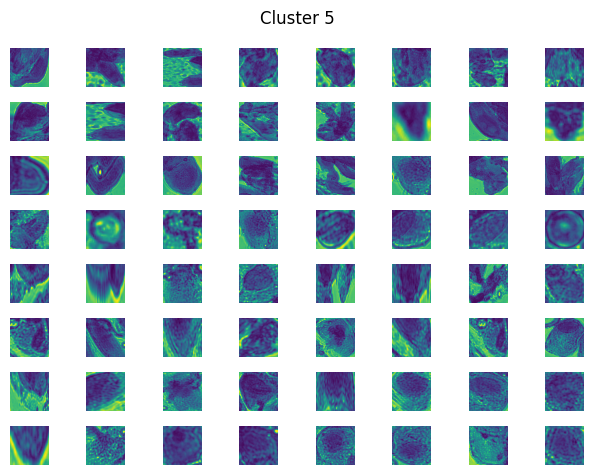

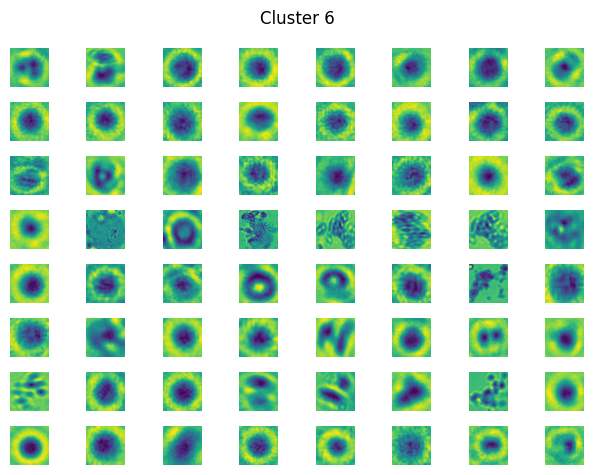

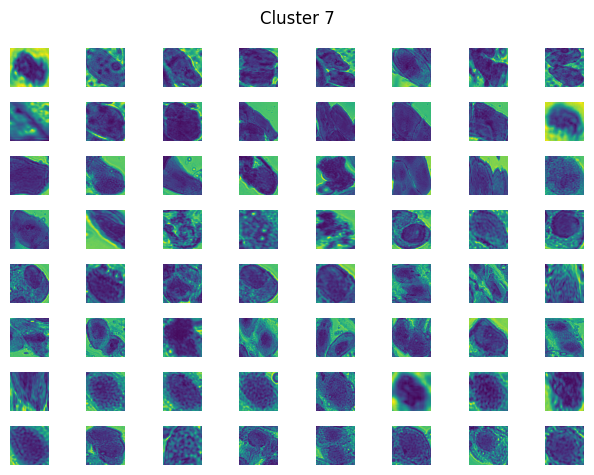

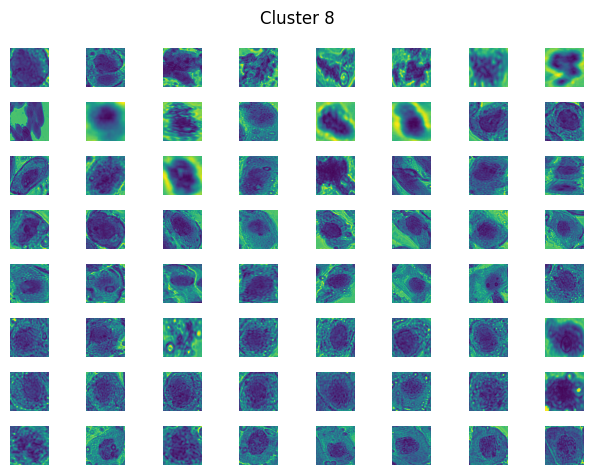

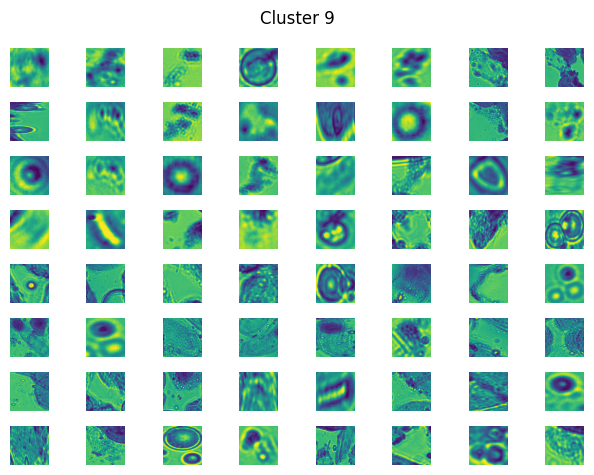

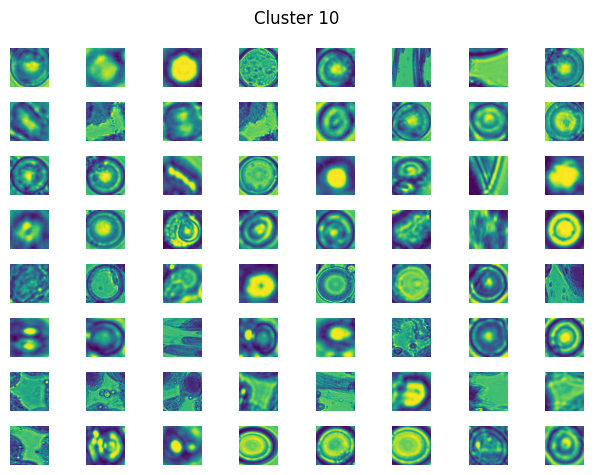

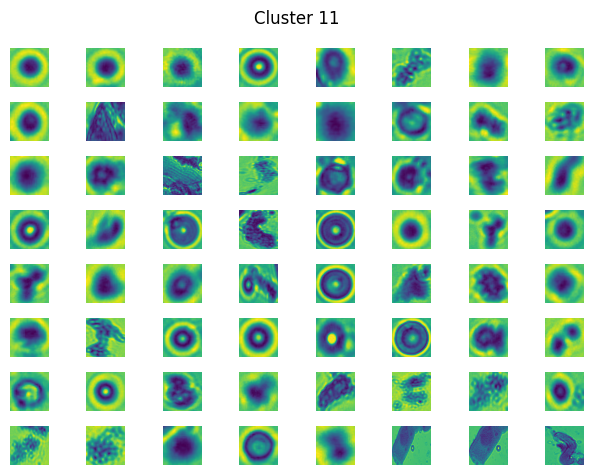

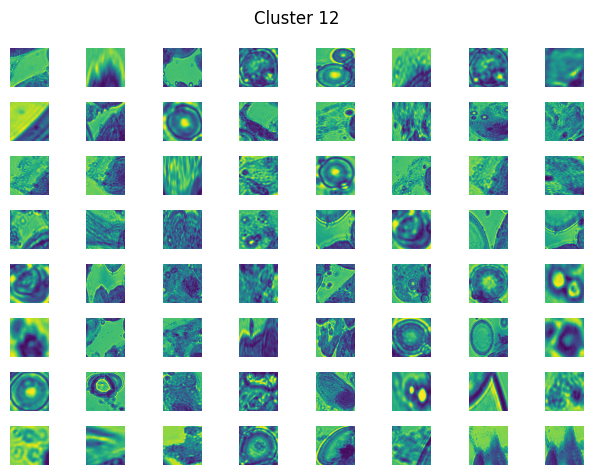

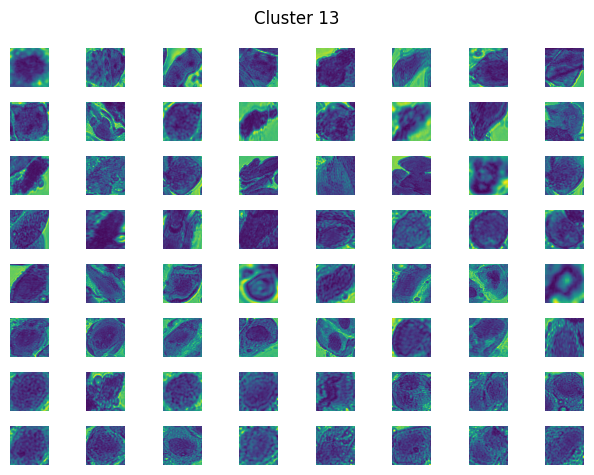

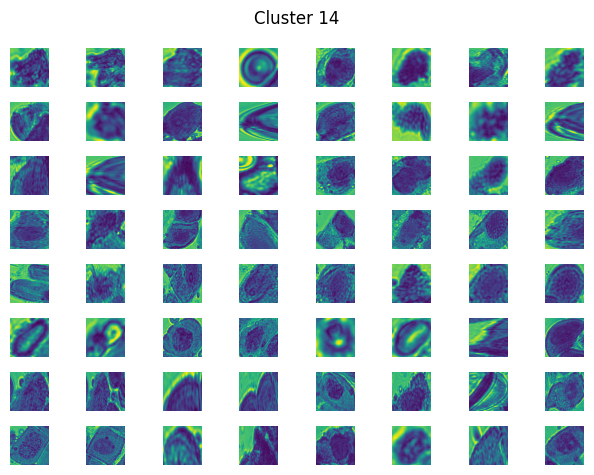

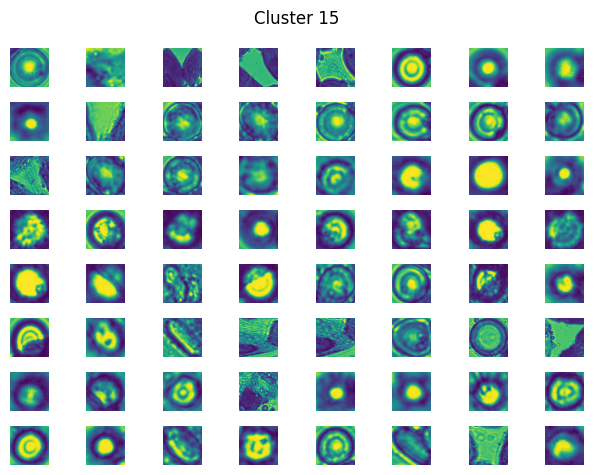

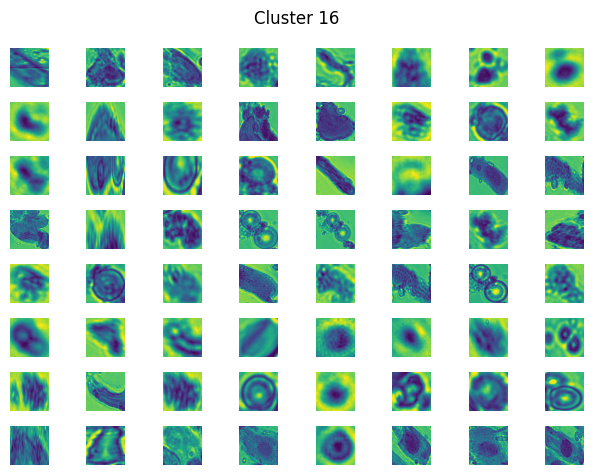

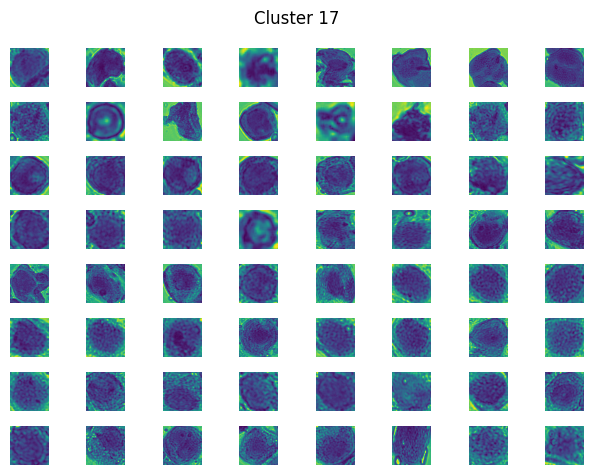

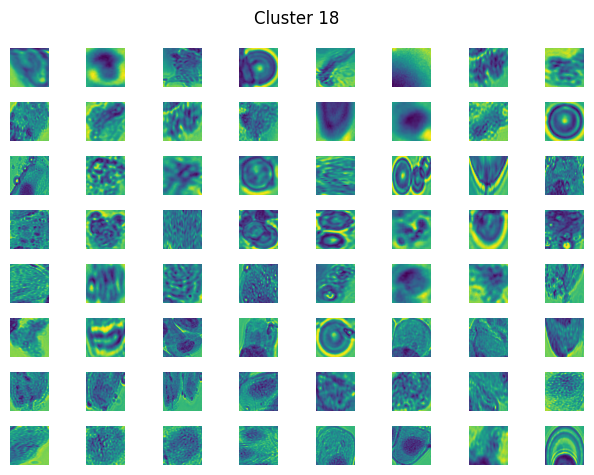

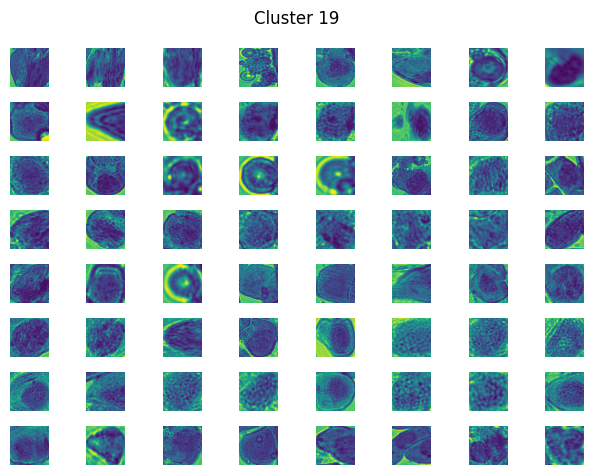

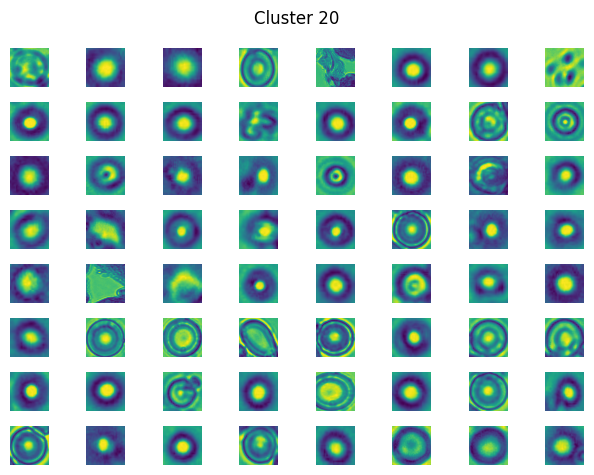

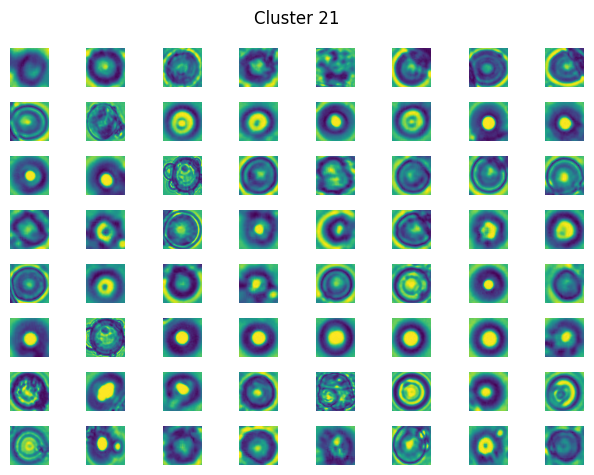

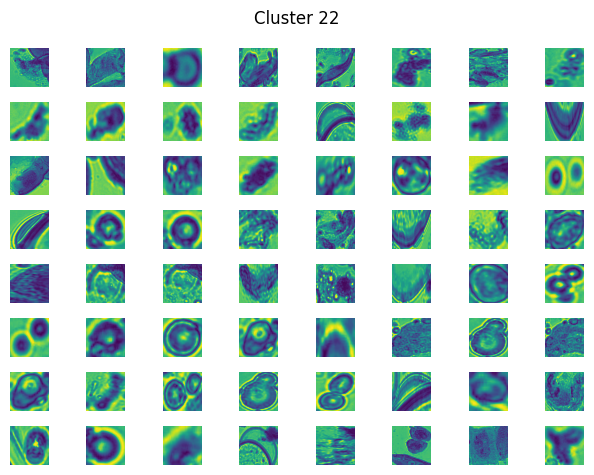

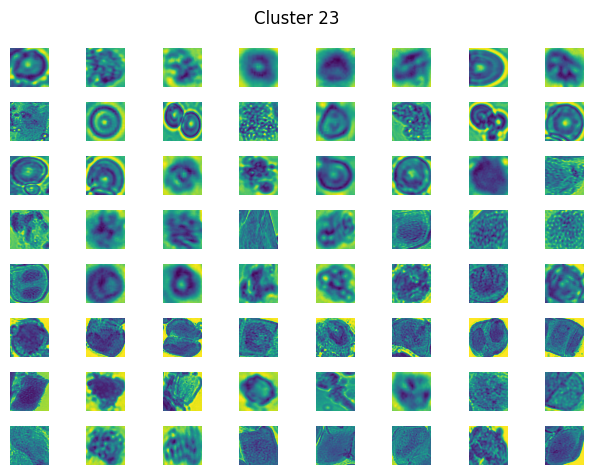

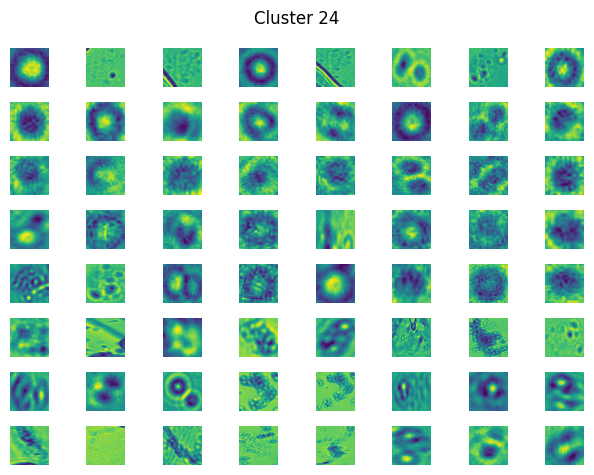

In [27]:
    
for rep_idx, rep_list in enumerate(rep_images):
    
    plt.figure()
    n = 1
    for image in rep_list:
        plt.subplot(GRID_SIZE,GRID_SIZE,n)
        plt.imshow(image)
        plt.axis(False)
        n+=1
    plt.suptitle(f"Cluster {rep_idx}")
    plt.tight_layout()

    plt.show()


### Create datasets

In [101]:
# if not os.path.exists('./output/noise'):
#     os.makedirs('./output/noise')

# if not os.path.exists('./output/cells'):
#     os.makedirs('./output/cells')

#### Get cluster representatrives

#### Create noise/cell dataset from predictions

In [22]:
raise ValueError("Pick a cluster MANUALLY!!!!! (this is to catch \"run all\" executions)")

ValueError: Pick a cluster MANUALLY!!!!! (this is to catch "run all" executions)

In [28]:
# Manually pick one
CELL_CLUSTERS = [4, 7, 8, 13, 17]
NOT_CLUSTERS=[0, 6, 9, 10, 11, 15, 16, 18, 24]

In [29]:
SPLIT = 0.7
realization_samples = dict()
for file in os.listdir(IMAGE_DIR):
    base, realiz, _ = file.split("_")
    if base not in realization_samples.keys():
        realization_samples[base]  = set()
    realization_samples[base].add(realiz)


train_samples = dict()
validation_samples = dict()
for key in realization_samples.keys():
    images_here = len(realization_samples[key])

    train_images_here = int(np.floor(images_here*SPLIT))
    this_train_sample = np.random.choice(list(realization_samples[key]), train_images_here, replace=False)
    if base not in train_samples.keys():
        train_samples[key]  = list()
        validation_samples[key]  = list()
    train_samples[key] = this_train_sample
    validation_samples[key] = [a for a in list(realization_samples[key]) if a not in this_train_sample]

print("Train:")
for key in train_samples.keys():
    print(key, len(train_samples[key]))
print("Validation:")
for key in validation_samples.keys():
    print(key, len(validation_samples[key]))

print(realization_samples)

Train:
003 57
004 92
001 58
005 8
002 50
Entrega1 6
Validation:
003 25
004 40
001 26
005 4
002 22
Entrega1 3
{'003': {'00062', '00028', '00058', '00061', '00026', '00041', '00032', '00057', '00068', '00001', '00029', '00077', '00006', '00036', '00050', '00040', '00025', '00078', '00046', '00053', '00012', '00023', '00071', '00063', '00039', '00076', '00069', '00042', '00051', '00005', '00027', '00070', '00007', '00008', '00035', '00049', '00003', '00030', '00009', '00014', '00018', '00064', '00010', '00079', '00045', '00011', '00004', '00054', '00021', '00024', '00016', '00056', '00059', '00002', '00081', '00060', '00037', '00048', '00038', '00020', '00033', '00047', '00067', '00034', '00074', '00052', '00015', '00055', '00066', '00073', '00017', '00082', '00072', '00031', '00065', '00044', '00022', '00075', '00019', '00043', '00080', '00013'}, '004': {'00090', '00058', '00028', '00086', '00062', '00061', '00101', '00026', '00041', '00032', '00057', '00068', '00001', '00132', '00029', 

In [30]:
max_class = 3500

# Random Shuffle
indices = np.arange(seleccted_class.shape[0])
np.random.shuffle(indices)
seleccted_class_shuffle = seleccted_class[indices]
image_paths_shuffle = np.array(image_paths)[indices]

if os.path.exists(output_path_dataset):
    shutil.rmtree(output_path_dataset)
os.makedirs(os.path.join(output_path_dataset, 'train', "not"))
os.makedirs(os.path.join(output_path_dataset, 'train', "cells"))
os.makedirs(os.path.join(output_path_dataset, 'validation', "not"))
os.makedirs(os.path.join(output_path_dataset, 'validation', "cells"))

for idx, cluster in enumerate(seleccted_class_shuffle):
    if cluster >= 0:
        if cluster in CELL_CLUSTERS:
            folder = "cells"
        elif cluster in NOT_CLUSTERS:
            folder = "not"
        else:
            continue

        file = image_paths_shuffle[idx]
        img_name = os.path.basename(file)
        base, realiz, _ = img_name.split("_")

        if realiz in train_samples[base]:
            split = "train"
        else:
            split = "validation"

        if len(os.listdir(os.path.join(output_path_dataset, split,folder))) >= max_class:
            continue
        
        
        shutil.copyfile(file, os.path.join(output_path_dataset, split, folder, img_name))



In [31]:
print(os.path.basename(output_path_dataset))

AutoEncoder_agglomerative_v2


In [32]:
print(len(os.listdir(os.path.join(output_path_dataset, "train", "not"))))
print(len(os.listdir(os.path.join(output_path_dataset, "train", "cells"))))
print(len(os.listdir(os.path.join(output_path_dataset, "validation", "not"))))
print(len(os.listdir(os.path.join(output_path_dataset, "validation", "cells"))))

3500
3500
3500
3176
